# Multi-spectral modelling of an RC telescope

Based on Toliman design, with no phase grating. This is just a demonstration of the approach for modelling a single stellar source image.

In [1]:
import numpy as np

toliman_settings = {
                    # Eduardo's values:
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 0.5717255, 
                    'm1_m2_sep': 0.54933763033373, 
                    'm2_fl': -0.02337895948640,  
                    'bfl': 0.52761,# Adjusted value to get proper focus (from BN)
                    'm2_rad': 0.00590401477581,
                    'm1_conic': -1.00011470000000,
                    'm2_conic': -1.16799179177759,
                    # Go for 5-fold symmetry to match assumed rosette
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    # Some other defaults
                    'beam_ratio': 0.2,
                    'tilt_x': 0.,
                    'tilt_y': 0.
                    }

n_wavelengths = 5
wl_min = 0.5 # micros -> 500 nm
wl_max = 0.6 # micros -> 600 nm
wavelengths = np.linspace(wl_min, wl_max, num=n_wavelengths)
print(wavelengths)

[ 0.5    0.525  0.55   0.575  0.6  ]


## Individual monochromatic PSFs

In [14]:
%matplotlib inline
import proper
import numpy as np
import matplotlib.pylab as plt

def gen_psfs(prescription,
                    prescription_vals,
                    wavelengths=[0.6],
                    gridsize = 2048):
    wavefronts = []
    samplings = []
    for wl in wavelengths:
        (wavefront, sampling) = proper.prop_run(prescription, wl, gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=prescription_vals)
        wavefronts.append(wavefront)
        samplings.append(sampling)
    return (wavefronts, samplings)

def plot_psfs(wavefronts,
                    gridsize = 2048, #512
                    sz = 80,
                 logscale=True):
    c = int(gridsize/2)

    fig, axes = plt.subplots(nrows=1, ncols=len(wavelengths),sharex=True, sharey=True, figsize=(10,2))
    for wavefront, ax in zip(wavefronts, axes.flat):
        frame = wavefront[c-sz:c+sz, c-sz:c+sz]
        if logscale is True:
            frame = np.log10(frame)
        im = ax.imshow(frame, interpolation = 'none', cmap='viridis')#, clim=[-7, -1.6])
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()

In [ ]:
(wfs, ss) = gen_psfs('prescription_rc_conic', toliman_settings, wavelengths=wavelengths, gridsize=2048) 


In [ ]:
%matplotlib inline
plot_psfs(wfs)

##  Combined version using `prop_run_multi`

Using `prop_run_multi` is equivalent to running `prop_run` multiple times with different wavelenths and/or `PASSVALUE` structures, except that:

1. Each `prop_run` call is dispatched to a separate thread via `pool.map`, allowing parallel operation (but breaking the savepoint feature)
2. The returned stack of wavefronts are collected into a 3D numpy array of type `complex128`, so each wavefront must be re-cast with `numpy.abs` to make them convertable to floats arrays for display.

In [ ]:
gridsize = 2048
(wavefronts, sampling) = proper.prop_run_multi('prescription_rc_conic', wavelengths, gridsize = gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=toliman_settings)

In [ ]:
plot_psfs(np.abs(wavefronts))

## Combining wavefronts to get detector intensities

PROPER offers `prop_pixellate` - from the manual:
> Integrate an image onto detector pixels of a specified size. This is done by convolving the Fourier transform
of the input image with a sinc function representing the transfer function of an idealized square pixel. This
is then Fourier transformed back, producing an array containing the image values integrated onto detector-sized
pixels but at the spacing of the input image. This array is then interpolated to produce the image
integrated onto detector-sized pixels with detector-pixel sampling. It is assumed that the spacing and size of
the detector pixels are the same.

So before using `prop_pixellate` we need to work out the intensities, presumably at (at least) double the frequency of the pixel pitch for Nyquist.

Note also from the section about **Polychromatic Imaging**:
> The issue of sampling is important when simulating a polychromatic image. Unless the user specifies a beam
diameter/grid width ratio when calling PROP_BEGIN, the PROPER routines will compute a monochromatic image
that is Nyquist-sampled for its particular wavelength. Adding a bunch of Nyquist-sampled, multi-wavelength images
together will create an invalid result. The monochromatic images must, in the end, have the same sampling (in terms
of meters per pixel). This can be achieved in two ways. The first is to specify, for each wavelength, a beam
diameter/grid width ratio when calling PROP_BEGIN that provides the desired sampling. If this method is used,
then the focal plane sampling should be chosen to be equal-to or finer-than the Nyquist sampling criterion at the
shortest wavelength. The diameter of the entrance aperture pattern relative to the grid should not grow too large,
which would result in wrap-around numerical artifacts. The alternative method is to compute a Nyquist-sampled (or
finer) image at each wavelength and resample each one to a common grid. This can be done using PROP_MAGNIFY
(with the CONSERVE_FLUX switch set) or PROP_PIXELLATE. This has some computational overhead due to the
resampling, but the author considers this the safest solution.

Example code is provided, which I've distilled here:
```python
lambda_min = 0.5
lambda_max = 0.7
nlambda = 9
gridsize = 256
npsf = 256
final_sampling = 1.5e-6

# generate array of wavelengths
wavelength = np.arange(nlambda) / (nlambda - 1.) * (lambda_max - lambda_min) + lambda_min

# generate monchromatic fields in parallel
(fields, sampling) = proper.prop_run_multi('multi_example', wavelength, gridsize)

# resample fields to same scale, convert to PSFs
psfs = np.zeros([nlambda, npsf, npsf], dtype = np.float64)
for i in range(nlambda):
    mag = sampling[i] / final_sampling
    field = proper.prop_magnify(fields[i,:,:], mag, npsf, CONSERVE = True)
    psfs[i,:,:] = np.abs(field)**2

# add PSFs together
psf = np.sum(psfs, axis = 0) / nlambda
```
**NOTE:** The prescription used (not included here) explicitly sets `NOABS=True` in its call to `prop_end`, so each wavefront is resampled in amplitude prior to combining the intensities.

In [3]:
gridsize = 2048
settings = toliman_settings.copy()
settings['noabs'] = True
(wavefronts, samplings) = proper.prop_run_multi('prescription_rc_conic', wavelengths, gridsize = gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=settings)



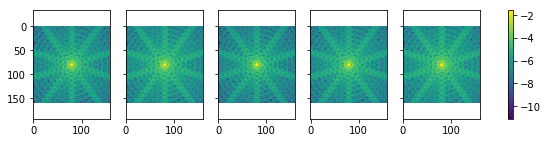

In [21]:
plot_psfs(np.abs(wavefronts)**2)

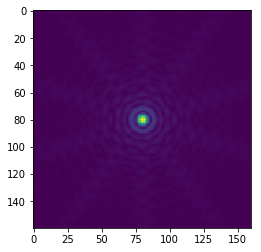

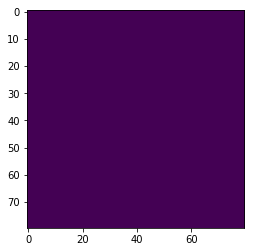

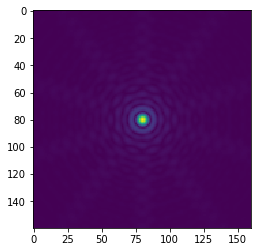

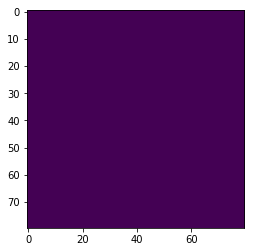

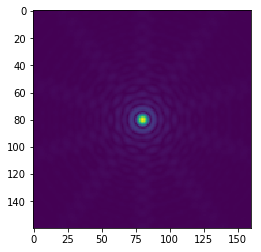

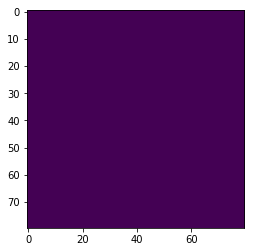

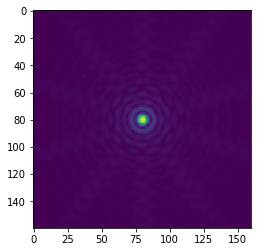

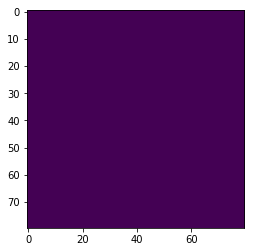

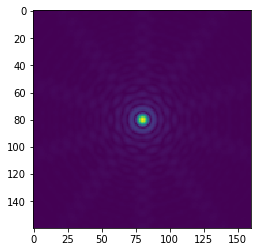

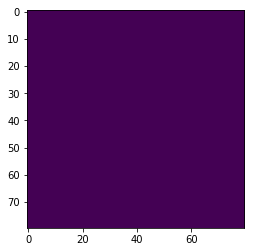

In [25]:
detector_pitch = 11.0e-6 # m/pixel
npixels = 512
npsf = npixels*2
common_sampling = detector_pitch/2. # for Nyquist 
wl_weights = [1.,1.,1.,1.,1.] # Relative intensity of each wavefront
norm = sum(wl_weights) # Rescale

psfs = np.zeros([n_wavelengths, npsf, npsf], dtype = np.float64)
# Resample and weight
for i in range(n_wavelengths):
    weight = wl_weights[i]/norm
    wf = wavefronts[i]
%    plt.imshow(np.abs(wf[1024-80:1024+80, 1024-80:1024+80]), interpolation = 'none', cmap='viridis')
    plt.show()
    mag = samplings[i] / common_sampling
    field = proper.prop_magnify(wavefronts[i,:,:], mag, npsf, CONSERVE = True)
%    plt.imshow(np.abs(field[1024-80:1024+80, 1024-80:1024+80]), interpolation = 'none', cmap='viridis')
    plt.show()
    psfs[i,:,:] = (np.abs(field)**2)*weight
    
psf = np.sum(psfs, axis=0)


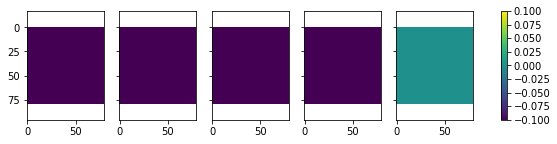

In [15]:
plot_psfs(psfs**2, logscale=False)

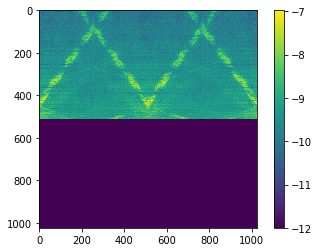

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.log10(psf+1e-12), interpolation = 'none', cmap='viridis')#, clim=[-7, -1.6])
plt.colorbar()
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sz = 200
c = int(1024/2)
    
plt.imshow(np.log10(psf[c-sz:c+sz, c-sz:c+sz]+1e-12), interpolation = 'none', cmap='viridis')#, clim=[-7, -1.6])
plt.colorbar()
plt.show()

In [ ]:
print(psf.shape[0])
detector_image = proper.prop_pixellate(psf, common_sampling, detector_pitch)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(detector_image, interpolation = 'none', cmap='viridis')#, clim=[-7, -1.6])
plt.colorbar()
plt.show()